In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.patches as mpatches

In [2]:
pip install community 

Note: you may need to restart the kernel to use updated packages.


In [3]:
df_review = pd.read_csv("yelp_academic_dataset_review.csv")
df_review = pd.DataFrame(df_review)

In [4]:
df_business = pd.read_csv("yelp_academic_dataset_business.csv")
df_business = pd.DataFrame(df_business)

In [5]:
df_user = pd.read_csv("yelp_academic_dataset_user.csv")
df_user = pd.DataFrame(df_user)

C:\Users\asus\AppData\Local\Temp\ipykernel_17664\1230748970.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_user = pd.read_csv("yelp_academic_dataset_user.csv")


In [37]:
df_review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


In [7]:
pip install pandas networkx matplotlib


VAMOS CRIAR UMA COMUNIDADE DE USERS COM BASE NOS AMIGOS DELES :)))

In [8]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [9]:
import networkx as nx
import pandas as pd
from community import community_louvain
import matplotlib.pyplot as plt

In [10]:
# Define relevant categories
relevant_categories = {
    'American (Traditional)', 'Italian', 'Mexican', 'Chinese', 'Indian', 
    'Japanese', 'Cafes', 'Bakeries', 'Mediterranean', 'Fast Food', 
    'Buffets', 'Food Trucks', 'Bars', 'Pubs', 'Steakhouses', 'Sushi Bars', 
    'Breakfast & Brunch', 'Sandwiches', 'Pizza', 'Seafood', 
    'Cocktail Bars', 'Ice Cream & Frozen Yogurt', 'Coffee & Tea', 
    'Desserts', 'Barbeque', 'Food Stands', 'Homemade', 'Street Food', 'Bistro', 
    'Sustainable Restaurants'
}

df_restaurants = df_business[
    (df_business['city'] == 'Philadelphia') & 
    (df_business['categories'].str.contains('Restaurants', na=False))
]

df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(
    lambda x: [cat for cat in x.split(', ') if cat in relevant_categories]
)

df_restaurants = df_restaurants[df_restaurants['relevant_categories'].str.len() > 0]

df_filtered_reviews = pd.merge(df_review, df_restaurants, on='business_id', how='inner')

# Limit 
first_users = df_filtered_reviews['user_id'].unique()[:100]
df_filtered_reviews = df_filtered_reviews[df_filtered_reviews['user_id'].isin(first_users)]

# G = nx.Graph()

# for business_id, group in df_filtered_reviews.groupby('business_id'):
#     users = group['user_id'].tolist()
#     # Add edges between users who reviewed the same business using combinations
#     for user1, user2 in combinations(users, 2):
#         if G.has_edge(user1, user2):
#             G[user1][user2]['weight'] += 1
#         else:
#             G.add_edge(user1, user2, weight=1)

# plt.figure(figsize=(10, 10))
# pos = nx.spring_layout(G, k=0.1)  # Force-directed layout
# nx.draw(G, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
# plt.title("User Interaction Network for Relevant Restaurants in Philadelphia")
# plt.show()

# print("Number of nodes (users):", G.number_of_nodes())
# print("Number of edges (interactions):", G.number_of_edges())

C:\Users\asus\AppData\Local\Temp\ipykernel_17664\2782354215.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(


Let's add the names of the people in the plot

In [11]:
relevant_categories = {
    'American (Traditional)', 'Italian', 'Mexican', 'Chinese', 'Indian', 
    'Japanese', 'Cafes', 'Bakeries', 'Mediterranean', 'Fast Food', 
    'Buffets', 'Food Trucks', 'Bars', 'Pubs', 'Steakhouses', 'Sushi Bars', 
    'Breakfast & Brunch', 'Sandwiches', 'Pizza', 'Seafood', 
    'Cocktail Bars', 'Ice Cream & Frozen Yogurt', 'Coffee & Tea', 
    'Desserts', 'Barbeque', 'Food Stands', 'Homemade', 'Street Food', 'Bistro', 
    'Sustainable Restaurants'
}

df_restaurants = df_business[ 
    (df_business['city'] == 'Philadelphia') & 
    (df_business['categories'].str.contains('Restaurants', na=False))
]

df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(
    lambda x: [cat for cat in x.split(', ') if cat in relevant_categories]
)

df_restaurants = df_restaurants[df_restaurants['relevant_categories'].str.len() > 0]

df_filtered_reviews = pd.merge(df_review, df_restaurants, on='business_id', how='inner')

first_five_users = df_filtered_reviews['user_id'].unique()[:100]
df_filtered_reviews = df_filtered_reviews[df_filtered_reviews['user_id'].isin(first_five_users)]


C:\Users\asus\AppData\Local\Temp\ipykernel_17664\3759004817.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(


In [12]:
len(first_five_users)

100

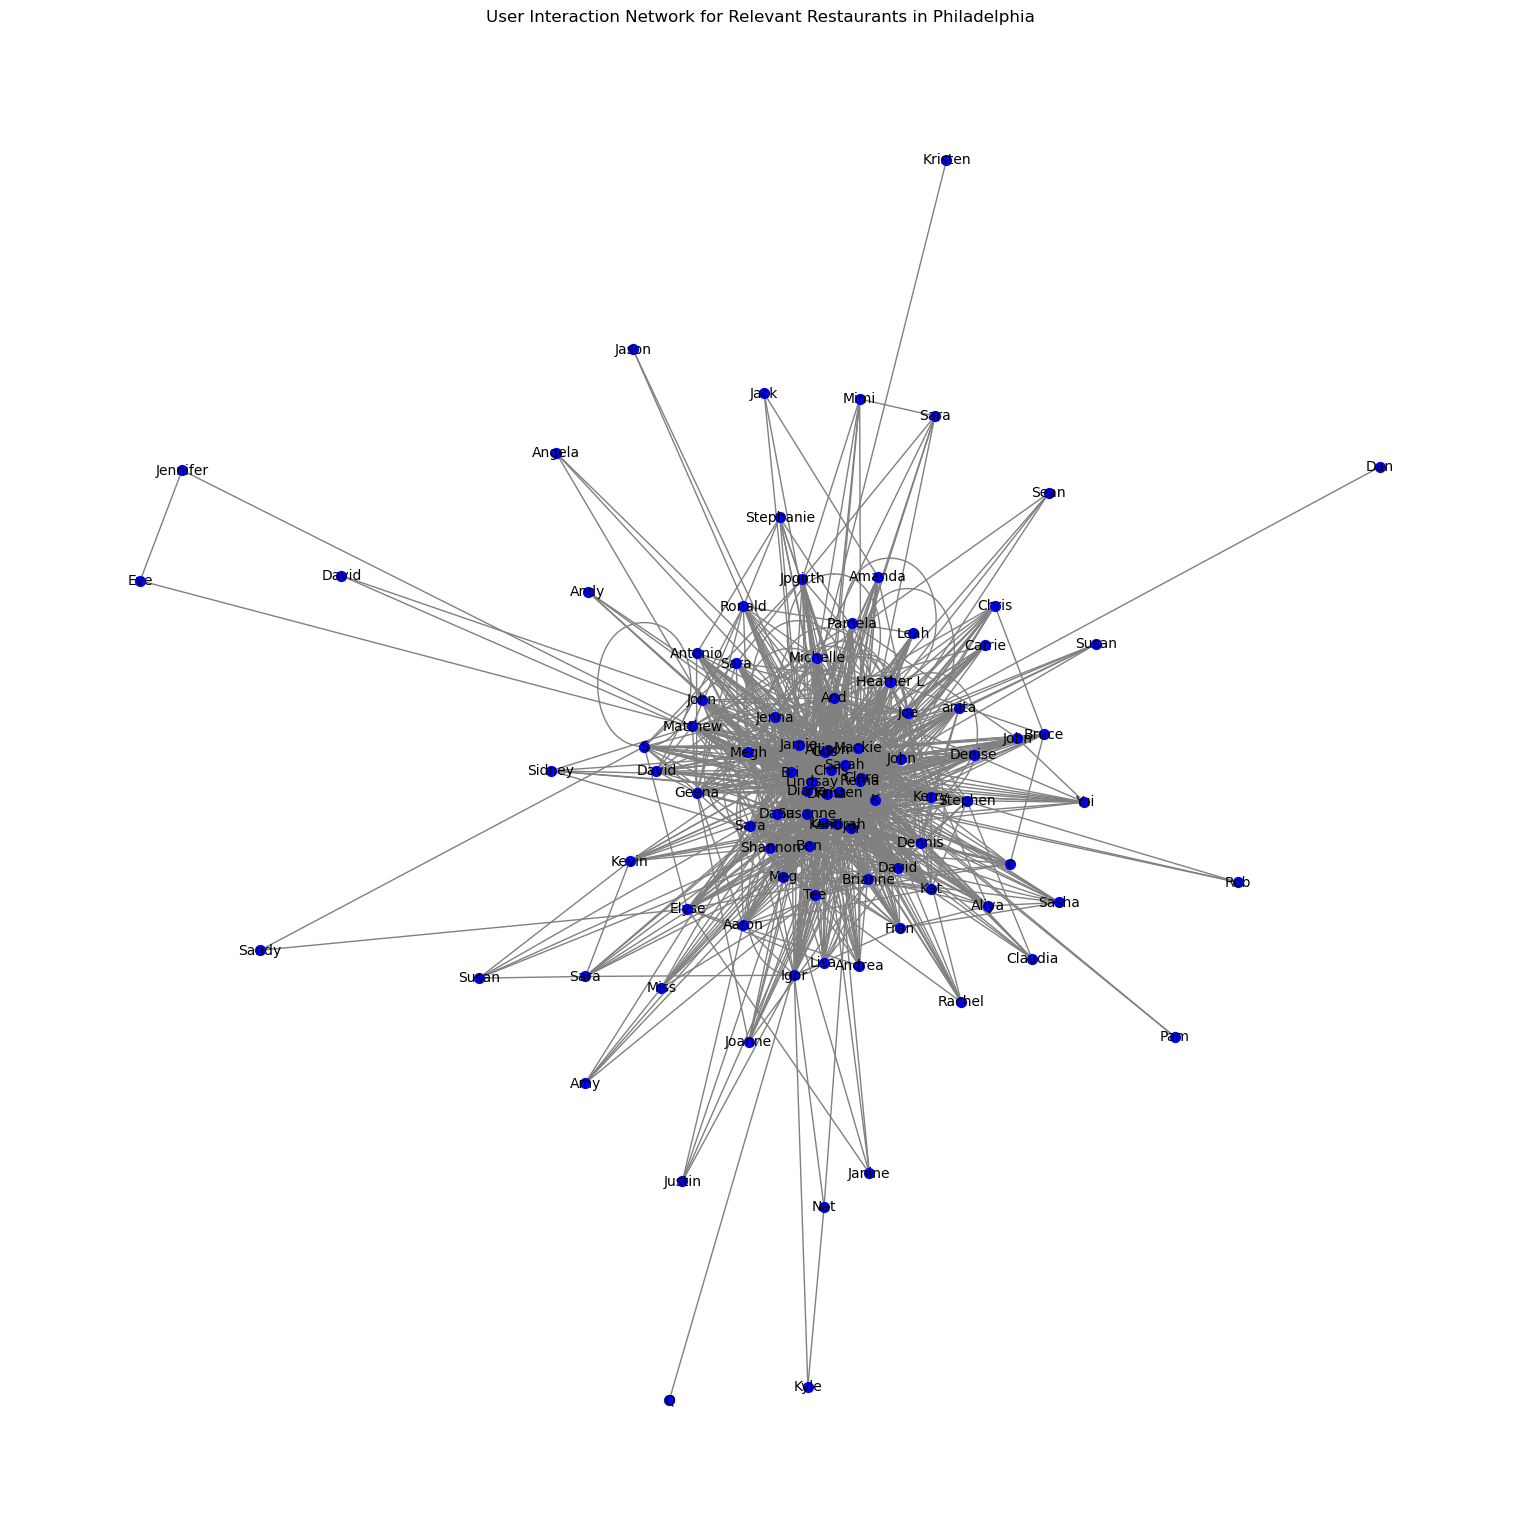

Number of nodes (users): 96
Number of edges (interactions): 1145


In [13]:
G = nx.Graph()

for business_id, group in df_filtered_reviews.groupby('business_id'):
    users = group['user_id'].tolist()
    # Add edges between users who reviewed the same business using combinations
    for user1, user2 in combinations(users, 2):
        if G.has_edge(user1, user2):
            G[user1][user2]['weight'] += 1
        else:
            G.add_edge(user1, user2, weight=1)

df_user_subset = df_user[df_user['user_id'].isin(G.nodes)]
user_names = df_user_subset.set_index('user_id')['name'].to_dict()

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.1)  # Force-directed layout
nx.draw(G, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos, labels=user_names, font_size=10)

plt.title("User Interaction Network for Relevant Restaurants in Philadelphia")
plt.show()

print("Number of nodes (users):", G.number_of_nodes())
print("Number of edges (interactions):", G.number_of_edges())


Same but using the same style from the plot of the business

Detected Communities:
Community 1: {'7Ie0VmQtnGYUVq2YW4dTVw', 'qsKXDTwhbsZtogfaKIyfoQ', 'OkjeFppodgJP_CvB84cJYw', '11xwVSDv1ytjcyvUiyBWaw', 'xE7AXFF9wVaN6id6OCtH3Q', 'zg2FNzIq6s7n41H1E5NnWg', 'JDBlafv8p0UBtVFZ4LnRhw', 'tGMnQ1EnvZqpn_jAuN8VsA', 'G0DHgkSsDozqUPWtlxVEMw', '9oHOoqk-HlwDS2DlHLi_0g', 'TmdJhSSDABdUwuci8HhbBw', 'dme9K6sQrgpojAay5r8IAA', 'vr-Rw3nMKIgGrVNT6A7p9g', 'DUgvASMlwPxHKe6LZSmO4w', 'mzXDuhZBPdHfMIk1YXP0mQ', 'bqmbKKNZnutdZuvzxifTBA', '2XBcnIVhp_pEeer-asuxHA', 'BmThnFPDalpbC1x98aXKaw', 'gSEhdaQNcewg-ob6xSgleQ', 'LcVPBNUeENzPlXNbZ2jTQw', 'Yr7tRi9b5-Na2FWP5ihG2A', 'mqBWACmaHflW4eh_Ofp16Q', 'ZGjgfSvjQK886kiTzLwfLQ', '7HOTNEzVwtJQK6iwC6XVJA', '5kcLlhJPLJL_GLwrAdbZAA', 'oQUyojSOb6rdMnusw0M5lg', 'Cvi8nZTwDVaQkqmmgQwQMw', 'Z5j9Xw_G0c7M2b1-iS67wg', '1M1HMZO1_TuTS5tQbHKIgg', 'xy73BfEs7UKuT1PImQWM1g', 'Dd1jQj7S-BFGqRbApFzCFw', 'vFd8aBLg1kFcd0kCkoi-xw', 'Xj4NPAq2efs4mzS4kFHGyQ', 'OfhZlqYMrCVAhM-bt_cQug', 'xjQSpme1Z7Xw8XehRLpYuA', '7ktyPHE-NGnWxarOqjIQiQ', 'ZINyxsYek_RF6jrUmQ_zDw', 'X

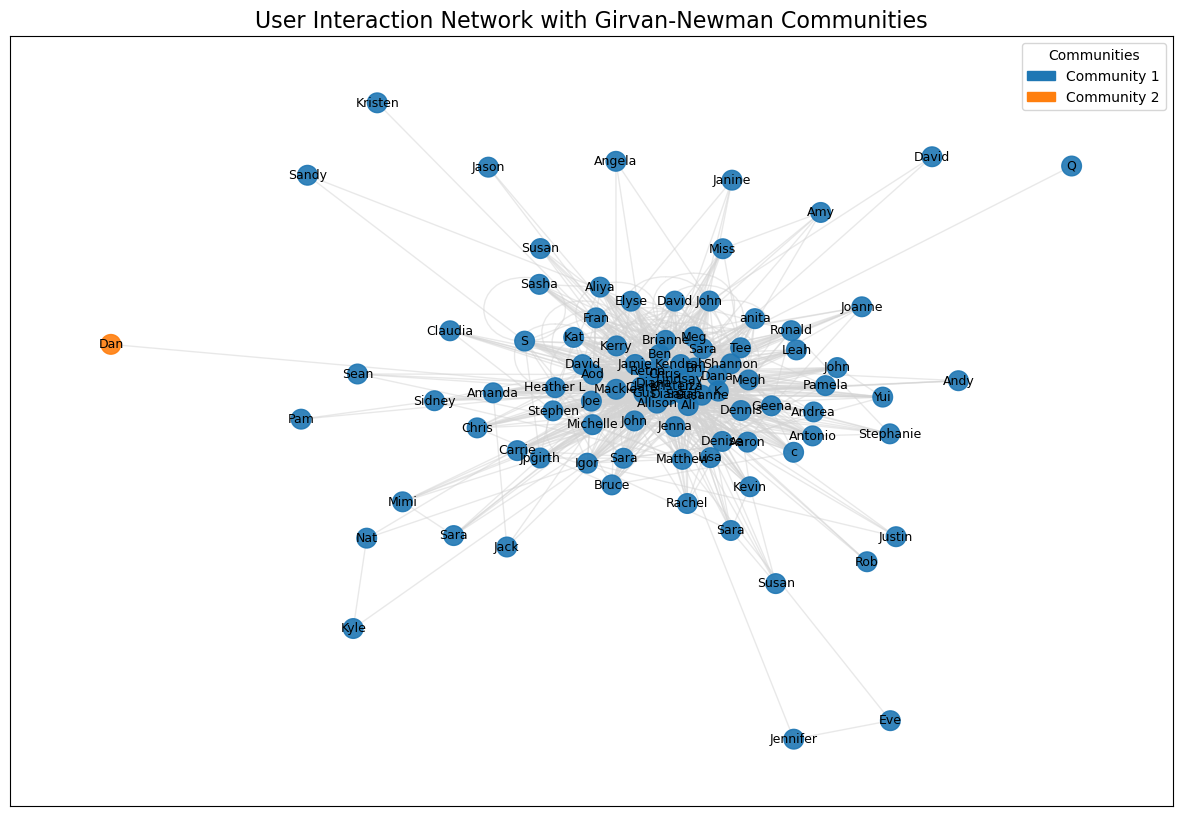

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming you have already created the user interaction network `G`
# Using the Girvan-Newman algorithm to detect communities
communities_generator = nx.community.girvan_newman(G)
first_community = next(communities_generator)  # Get the first set of communities
first_community = list(first_community)  # Convert to list format

# Print out the detected communities
print("Detected Communities:")
for i, community in enumerate(first_community):
    print(f"Community {i + 1}: {community}")

# Visualize the user interaction network with detected communities
plt.figure(figsize=(15, 10))

# Define distinct colors for communities
community_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Map nodes to community colors
color_map = {}
for idx, community in enumerate(first_community):
    for node in community:
        color_map[node] = community_colors[idx % len(community_colors)]  
# Get positions for nodes using spring layout
pos = nx.spring_layout(G, k=0.15, seed=42)  # Adjust k for spacing and seed for reproducibility

# Draw nodes with community colors
nx.draw_networkx_nodes(G, pos, node_color=[color_map[node] for node in G.nodes()], node_size=200, alpha=0.9)

# Draw edges with a consistent color and transparency
nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1, alpha=0.5)
df_user_subset = df_user[df_user['user_id'].isin(G.nodes)]
user_names = df_user_subset.set_index('user_id')['name'].to_dict()
# Draw labels using the `user_names` 
nx.draw_networkx_labels(G, pos, labels=user_names, font_size=9, font_color='black')

# Title and layout
plt.title('User Interaction Network with Girvan-Newman Communities', fontsize=16)

# Create a legend for the communities
handles = []
for idx, community in enumerate(first_community):
    patch = mpatches.Patch(color=community_colors[idx % len(community_colors)], label=f'Community {idx + 1}')
    handles.append(patch)

# Display the legend
plt.legend(handles=handles, loc='best', title="Communities", fontsize=10)

# Show the final plot
plt.show()


Again, Newman method is not good, so let's use the same used in Business

Detected Communities:
Community 1: ['2XBcnIVhp_pEeer-asuxHA', 'BmThnFPDalpbC1x98aXKaw', 'i1jYqpHfyu2LB9c5zezLEQ', 'qsKXDTwhbsZtogfaKIyfoQ', 'JW5W4OZCohTvZlRF1jzrTg', 'gSEhdaQNcewg-ob6xSgleQ', 'j6auVeGydK6FavvcyHu_Zw', 'Yr7tRi9b5-Na2FWP5ihG2A', 'xE7AXFF9wVaN6id6OCtH3Q', 'mmdf_Fi-Hh_3uZN5zE164A', 'g2GDpnMMXO9s0-JVIJnfzQ', 'JggphOM7FIbvUyPcsfcNTw', 'boC2VXdYY0bs4vOw_jD4bQ', '5kcLlhJPLJL_GLwrAdbZAA', 'zg2FNzIq6s7n41H1E5NnWg', 'JDBlafv8p0UBtVFZ4LnRhw', 'tgZ0r69ap3_-sNBgLPZsPw', 'Au2RZKzmrr75h2bBpb60oA', '4KNOhaUhegpmZ6sWwJtRTw', '7ktyPHE-NGnWxarOqjIQiQ', 'av5_rihz1f5DLEIt5NrtNA', 'aFa96pz67TwOFu4Weq5Agg', 'nBUnQnecIYYWuxk0g5njhw', 'ZPYPQvM1DMZB39oQ9WlDgw', 'wABHp4fGUC-0acRKhmQO2A', 'QvIZleI1KG46yFMRSWrYcQ', 'qz1XgXvvtRR8WKyWUXSJig', '2DhNGmmyDmnZdZps49U9VQ', 'vqaJs9VyVLkbixSetsVKyQ', 'hWDybu_KvYLSdEFzGrniTw', 'RhqQNwLWCHArpTwhlaiM9A', '-5X3pQ0XrdZqNU1LHQPnpg']
Community 2: ['eUta8W_HdHMXPzLBBZhL1A', 'DEiAhP-xb4i-71foPKSqxQ', 'smOvOajNG0lS4Pq7d8g4JQ', 'zDWhnidBcEok7Vqnu-AnMg', 'OfhZlqYMrCVAh

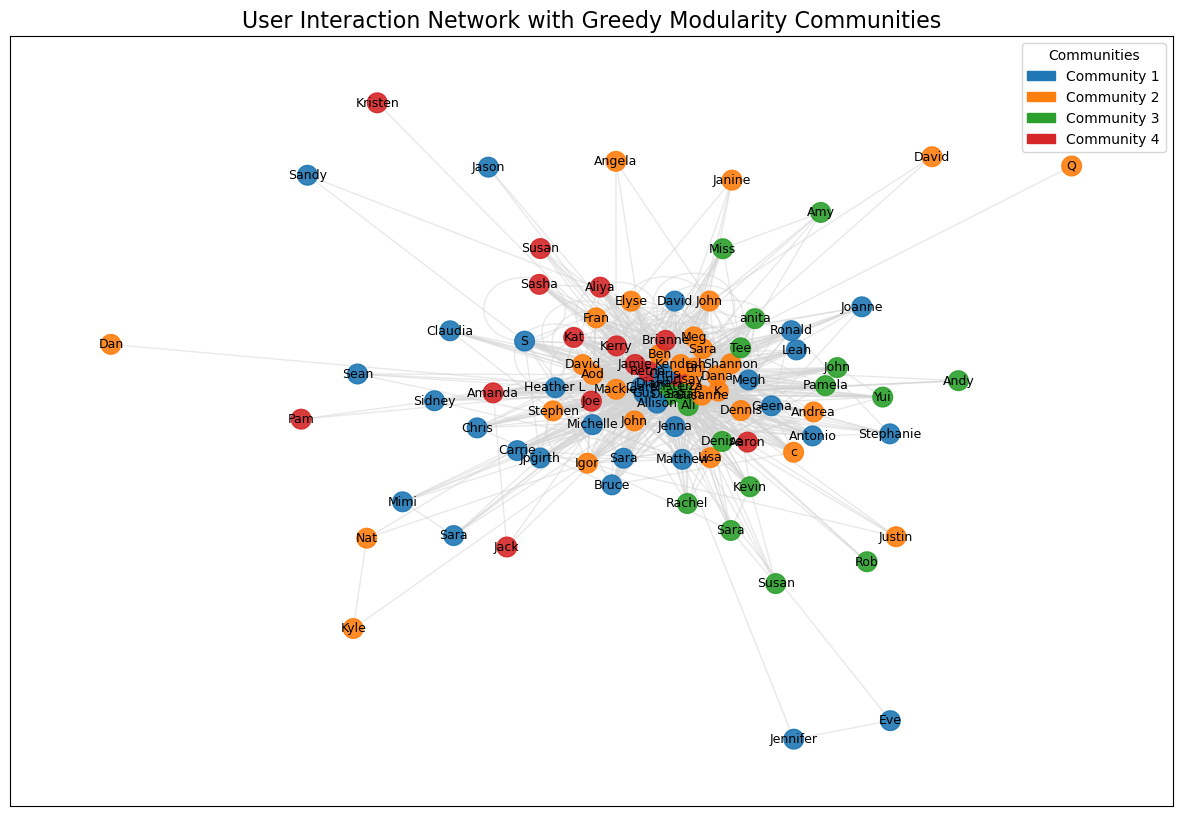

In [15]:


# Assuming the user interaction network `G` has already been created
communities = list(nx.algorithms.community.greedy_modularity_communities(G))

print("Detected Communities:")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {list(community)}")

plt.figure(figsize=(15, 10))

community_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
                    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

color_map = {}
for idx, community in enumerate(communities):
    for node in community:
        color_map[node] = community_colors[idx % len(community_colors)]  # Cycle through colors

pos = nx.spring_layout(G, k=0.15, seed=42)  # Adjust k for spacing and seed for reproducibility

nx.draw_networkx_nodes(G, pos, node_color=[color_map[node] for node in G.nodes()], node_size=200, alpha=0.9)

nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1, alpha=0.5)

df_user_subset = df_user[df_user['user_id'].isin(G.nodes)]
user_names = df_user_subset.set_index('user_id')['name'].to_dict()

nx.draw_networkx_labels(G, pos, labels=user_names, font_size=9, font_color='black')

plt.title('User Interaction Network with Greedy Modularity Communities', fontsize=16)

handles = []
for idx, community in enumerate(communities):
    patch = mpatches.Patch(color=community_colors[idx % len(community_colors)], label=f'Community {idx + 1}')
    handles.append(patch)

plt.legend(handles=handles, loc='best', title="Communities", fontsize=10)

plt.show()



I see a lot of circularity, so I want to get rid of it for simplicity

Detected Communities (after converting to directed graph):
Community 1: ['eUta8W_HdHMXPzLBBZhL1A', 'DEiAhP-xb4i-71foPKSqxQ', 'smOvOajNG0lS4Pq7d8g4JQ', 'zDWhnidBcEok7Vqnu-AnMg', 'OfhZlqYMrCVAhM-bt_cQug', '9oHOoqk-HlwDS2DlHLi_0g', 'aWlojpSpzEICTza3RgGJgg', 'OkjeFppodgJP_CvB84cJYw', 'au30JemWvCjjTp5vWdOLow', 'xjQSpme1Z7Xw8XehRLpYuA', 'oMNtNOXYFN0qdSCSfOfTOg', 'TmdJhSSDABdUwuci8HhbBw', '1M1HMZO1_TuTS5tQbHKIgg', 'tGMnQ1EnvZqpn_jAuN8VsA', '11xwVSDv1ytjcyvUiyBWaw', 'dme9K6sQrgpojAay5r8IAA', 'ZINyxsYek_RF6jrUmQ_zDw', 'XTWdXSOoUJnIMiVSA-1gDg', 'HYvQKlH_LaPG8-FuJqTw1w', 'kSMOJwJXuEUqzfmuFncK4A', '_7bHUi9Uuf5__HHc_Q8guQ', 'IQsF3Rc6IgCzjVV9DE8KXg', 'mqBWACmaHflW4eh_Ofp16Q', 'AGyh5jnM0zrIElY7aZQafQ', 'ZGjgfSvjQK886kiTzLwfLQ', '__GHy1xxetn0SBqP4b_odA', 'ndgHYecgAWEqtjnjE7LtfA', '16yfdXvoj6ra0hqFjLu2cQ', 'mNITUu6B2wUKBOa4NmUHJg', 'uAu772KpSkb-tPFgZmU-lA', 'QrVzVbFQ7vyePxrowVSe4w', 'mzXDuhZBPdHfMIk1YXP0mQ']
Community 2: ['Au2RZKzmrr75h2bBpb60oA', '2XBcnIVhp_pEeer-asuxHA', '4KNOhaUhegpmZ6sWwJtRTw', 'Bm

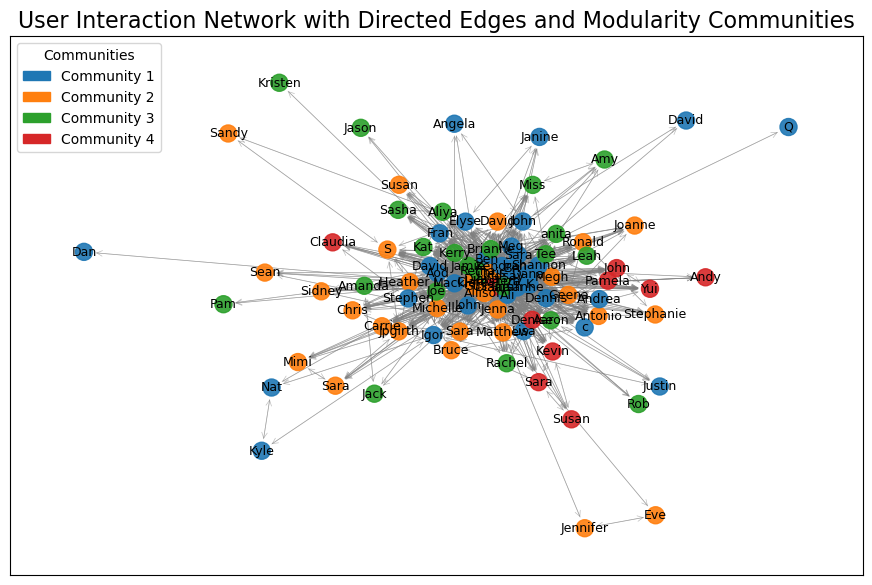

In [16]:
# Convert the graph to a directed graph to better represent direct interactions
# If you want to prune weak connections, consider converting to a directed graph (DiGraph)
G_directed = nx.DiGraph(G)  # Convert the existing graph to a directed one

# Optionally, remove self-loops (connections where a node connects to itself)
G_directed.remove_edges_from(nx.selfloop_edges(G_directed))

# Detect communities again in the new graph
communities = list(nx.algorithms.community.greedy_modularity_communities(G_directed))

print("Detected Communities (after converting to directed graph):")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {list(community)}")

plt.figure(figsize=(11, 7))

community_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

color_map = {}
for idx, community in enumerate(communities):
    for node in community:
        color_map[node] = community_colors[idx % len(community_colors)]  # Cycle through colors

pos = nx.spring_layout(G_directed, k=0.15, seed=42)  # Adjust `k` for spacing, `seed` for reproducibility

nx.draw_networkx_nodes(G_directed, pos, node_color=[color_map[node] for node in G_directed.nodes()],
                       node_size=150, alpha=0.9)

# Draw directed edges with arrows to show directionality
nx.draw_networkx_edges(G_directed, pos, edge_color='gray', arrows=True, arrowstyle='->', width=0.5, alpha=0.5)

df_user_subset = df_user[df_user['user_id'].isin(G_directed.nodes)]
user_names = df_user_subset.set_index('user_id')['name'].to_dict()
nx.draw_networkx_labels(G_directed, pos, labels=user_names, font_size=9, font_color='black')

plt.title('User Interaction Network with Directed Edges and Modularity Communities', fontsize=16)
handles = []
for idx, community in enumerate(communities):
    patch = mpatches.Patch(color=community_colors[idx % len(community_colors)], label=f'Community {idx + 1}')
    handles.append(patch)
plt.legend(handles=handles, loc='best', title="Communities", fontsize=10)
plt.show()


Top, muito melhor! Mas agora não sei muito bem o que fazer com isto, vou ver as métricas:

In [17]:
degree_centrality = nx.degree_centrality(G_directed)
betweenness_centrality = nx.betweenness_centrality(G_directed)
closeness_centrality = nx.closeness_centrality(G_directed)

def print_top_centrality(centrality_dict, centrality_name):
    sorted_users = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)
    
    print(f"\n{centrality_name}:")
    for user_id, centrality in sorted_users[:5]: 
        user_name = user_names.get(user_id, user_id) 
        print(f"User: {user_name}, {centrality_name}: {centrality:.4f}")

print_top_centrality(degree_centrality, "Degree Centrality")
print_top_centrality(betweenness_centrality, "Betweenness Centrality")
print_top_centrality(closeness_centrality, "Closeness Centrality")



Degree Centrality:
User: Kristen, Degree Centrality: 1.4947
User: Gus, Degree Centrality: 1.3895
User: Diana, Degree Centrality: 1.3053
User: Clare, Degree Centrality: 1.3053
User: Chris, Degree Centrality: 1.3053

Betweenness Centrality:
User: Kristen, Betweenness Centrality: 0.0677
User: Mackie, Betweenness Centrality: 0.0631
User: Clare, Betweenness Centrality: 0.0592
User: Chris, Betweenness Centrality: 0.0560
User: Gus, Betweenness Centrality: 0.0525

Closeness Centrality:
User: Kristen, Closeness Centrality: 0.7983
User: Gus, Closeness Centrality: 0.7661
User: Diana, Closeness Centrality: 0.7422
User: Clare, Closeness Centrality: 0.7422
User: Chris, Closeness Centrality: 0.7422


In [18]:
# Assuming the user interaction network `G` has already been created
communities = list(nx.algorithms.community.greedy_modularity_communities(G))

print("Detected Communities:")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {list(community)}")

# Calculate Degree Centrality for each node
degree_centrality = nx.degree_centrality(G)

Detected Communities:
Community 1: ['2XBcnIVhp_pEeer-asuxHA', 'BmThnFPDalpbC1x98aXKaw', 'i1jYqpHfyu2LB9c5zezLEQ', 'qsKXDTwhbsZtogfaKIyfoQ', 'JW5W4OZCohTvZlRF1jzrTg', 'gSEhdaQNcewg-ob6xSgleQ', 'j6auVeGydK6FavvcyHu_Zw', 'Yr7tRi9b5-Na2FWP5ihG2A', 'xE7AXFF9wVaN6id6OCtH3Q', 'mmdf_Fi-Hh_3uZN5zE164A', 'g2GDpnMMXO9s0-JVIJnfzQ', 'JggphOM7FIbvUyPcsfcNTw', 'boC2VXdYY0bs4vOw_jD4bQ', '5kcLlhJPLJL_GLwrAdbZAA', 'zg2FNzIq6s7n41H1E5NnWg', 'JDBlafv8p0UBtVFZ4LnRhw', 'tgZ0r69ap3_-sNBgLPZsPw', 'Au2RZKzmrr75h2bBpb60oA', '4KNOhaUhegpmZ6sWwJtRTw', '7ktyPHE-NGnWxarOqjIQiQ', 'av5_rihz1f5DLEIt5NrtNA', 'aFa96pz67TwOFu4Weq5Agg', 'nBUnQnecIYYWuxk0g5njhw', 'ZPYPQvM1DMZB39oQ9WlDgw', 'wABHp4fGUC-0acRKhmQO2A', 'QvIZleI1KG46yFMRSWrYcQ', 'qz1XgXvvtRR8WKyWUXSJig', '2DhNGmmyDmnZdZps49U9VQ', 'vqaJs9VyVLkbixSetsVKyQ', 'hWDybu_KvYLSdEFzGrniTw', 'RhqQNwLWCHArpTwhlaiM9A', '-5X3pQ0XrdZqNU1LHQPnpg']
Community 2: ['eUta8W_HdHMXPzLBBZhL1A', 'DEiAhP-xb4i-71foPKSqxQ', 'smOvOajNG0lS4Pq7d8g4JQ', 'zDWhnidBcEok7Vqnu-AnMg', 'OfhZlqYMrCVAh

In [19]:
community_metrics = {}

for i, community in enumerate(communities):
    community_centrality = [degree_centrality[node] for node in community]

    mean_community = sum(community_centrality) / len(community_centrality) if community_centrality else 0
    sum_community = sum(community_centrality)

    subgraph = G.subgraph(community)

    edges = subgraph.edges(data=True)
    total_weight = sum(edge[2]['weight'] for edge in edges)
    num_edges = len(edges)
    average_weight = total_weight / num_edges if num_edges > 0 else 0

    community_metrics[f"Community {i + 1}"] = {
        "Size": len(community),
        "Number of Edges": num_edges,
        "Total Weight": total_weight,
        "Average Weight": average_weight,
        "Mean Degree Centrality": mean_community,
        "Sum Degree Centrality": sum_community
    }

for community, metrics in community_metrics.items():
    print(f"\n{community}:")
    print(f"  Size: {metrics['Size']} nodes")
    print(f"  Number of Edges: {metrics['Number of Edges']}")
    print(f"  Total Weight of Edges: {metrics['Total Weight']:.2f}")
    print(f"  Average Weight of Edges: {metrics['Average Weight']:.2f}")
    print(f"  Mean Degree Centrality: {metrics['Mean Degree Centrality']:.4f}")
    print(f"  Sum of Degree Centrality: {metrics['Sum Degree Centrality']:.4f}")





Community 1:
  Size: 32 nodes
  Number of Edges: 155
  Total Weight of Edges: 603.00
  Average Weight of Edges: 3.89
  Mean Degree Centrality: 0.2309
  Sum of Degree Centrality: 7.3895

Community 2:
  Size: 31 nodes
  Number of Edges: 192
  Total Weight of Edges: 542.00
  Average Weight of Edges: 2.82
  Mean Degree Centrality: 0.2747
  Sum of Degree Centrality: 8.5158

Community 3:
  Size: 18 nodes
  Number of Edges: 64
  Total Weight of Edges: 322.00
  Average Weight of Edges: 5.03
  Mean Degree Centrality: 0.2503
  Sum of Degree Centrality: 4.5053

Community 4:
  Size: 15 nodes
  Number of Edges: 49
  Total Weight of Edges: 558.00
  Average Weight of Edges: 11.39
  Mean Degree Centrality: 0.2463
  Sum of Degree Centrality: 3.6947


Now i want to get all the restaurants that the users from Comunity 3 and 4 went to

In [29]:
community_1_users=  ['eUta8W_HdHMXPzLBBZhL1A', 'DEiAhP-xb4i-71foPKSqxQ', 'smOvOajNG0lS4Pq7d8g4JQ', 'zDWhnidBcEok7Vqnu-AnMg', 'OfhZlqYMrCVAhM-bt_cQug', '9oHOoqk-HlwDS2DlHLi_0g', 'aWlojpSpzEICTza3RgGJgg', 'OkjeFppodgJP_CvB84cJYw', 'au30JemWvCjjTp5vWdOLow', 'xjQSpme1Z7Xw8XehRLpYuA', 'oMNtNOXYFN0qdSCSfOfTOg', 'TmdJhSSDABdUwuci8HhbBw', '1M1HMZO1_TuTS5tQbHKIgg', 'tGMnQ1EnvZqpn_jAuN8VsA', '11xwVSDv1ytjcyvUiyBWaw', 'dme9K6sQrgpojAay5r8IAA', 'ZINyxsYek_RF6jrUmQ_zDw', 'XTWdXSOoUJnIMiVSA-1gDg', 'HYvQKlH_LaPG8-FuJqTw1w', 'kSMOJwJXuEUqzfmuFncK4A', '_7bHUi9Uuf5__HHc_Q8guQ', 'IQsF3Rc6IgCzjVV9DE8KXg', 'mqBWACmaHflW4eh_Ofp16Q', 'AGyh5jnM0zrIElY7aZQafQ', 'ZGjgfSvjQK886kiTzLwfLQ', '__GHy1xxetn0SBqP4b_odA', 'ndgHYecgAWEqtjnjE7LtfA', '16yfdXvoj6ra0hqFjLu2cQ', 'mNITUu6B2wUKBOa4NmUHJg', 'uAu772KpSkb-tPFgZmU-lA', 'QrVzVbFQ7vyePxrowVSe4w', 'mzXDuhZBPdHfMIk1YXP0mQ']
community_2_users= ['Au2RZKzmrr75h2bBpb60oA', '2XBcnIVhp_pEeer-asuxHA', '4KNOhaUhegpmZ6sWwJtRTw', 'BmThnFPDalpbC1x98aXKaw', 'i1jYqpHfyu2LB9c5zezLEQ', 'qsKXDTwhbsZtogfaKIyfoQ', '2DhNGmmyDmnZdZps49U9VQ', 'JW5W4OZCohTvZlRF1jzrTg', '7ktyPHE-NGnWxarOqjIQiQ', 'gSEhdaQNcewg-ob6xSgleQ', 'j6auVeGydK6FavvcyHu_Zw', 'av5_rihz1f5DLEIt5NrtNA', 'Yr7tRi9b5-Na2FWP5ihG2A', 'aFa96pz67TwOFu4Weq5Agg', 'xE7AXFF9wVaN6id6OCtH3Q', 'mmdf_Fi-Hh_3uZN5zE164A', 'g2GDpnMMXO9s0-JVIJnfzQ', 'JggphOM7FIbvUyPcsfcNTw', 'boC2VXdYY0bs4vOw_jD4bQ', '5kcLlhJPLJL_GLwrAdbZAA', 'zg2FNzIq6s7n41H1E5NnWg', 'QvIZleI1KG46yFMRSWrYcQ', 'JDBlafv8p0UBtVFZ4LnRhw', 'EYg-VaZlk13-blZxyohLDg', 'qz1XgXvvtRR8WKyWUXSJig', 'x-LrGPXN7WFX15Qk9B6_YQ', 'vqaJs9VyVLkbixSetsVKyQ', 'hWDybu_KvYLSdEFzGrniTw', 'RhqQNwLWCHArpTwhlaiM9A', '-5X3pQ0XrdZqNU1LHQPnpg']
community_3_users= ['xy73BfEs7UKuT1PImQWM1g', 'LqC5hNXcFVY-jcbyxi-tuQ', 'cARxOd_5yKCgsCbUZ5ED4Q', 'Zs8Zk3sgh5JxRmoZW4PJcg', 'qebLK4vwNUmv-Bqk3b2hTg', 'oQUyojSOb6rdMnusw0M5lg', 'A9Q-_QpJy1mHjlwwP2RwJg', 'duJnzlaILBFufu1wjyu-Bg', 'FBRjdSizGuMyxQuSSwzarg', 'ZGjgfSvjQK886kiTzLwfLQ', 'Cvi8nZTwDVaQkqmmgQwQMw', '7HOTNEzVwtJQK6iwC6XVJA', '2DOVDCbzd2X1cxs0YeFdrg', 'UYU71DRx-UDAee-eFOFfWw', 'ZaMB7VbOwaARjxdhXjODxA', 'bqmbKKNZnutdZuvzxifTBA', 'be1dU739NLAFbLw2S4RPhA', 'DUgvASMlwPxHKe6LZSmO4w']
community_4_users= ['Dd1jQj7S-BFGqRbApFzCFw', 'G0DHgkSsDozqUPWtlxVEMw', 'x-LrGPXN7WFX15Qk9B6_YQ', 'Z5j9Xw_G0c7M2b1-iS67wg', '98jv8gu7kAwa2WzIPdw6-w', 'vr-Rw3nMKIgGrVNT6A7p9g', 'vFd8aBLg1kFcd0kCkoi-xw', '_mLEJyBITb35hF-av1Q09Q', 'M-00xuAOYLeaGEhPmmKjfg', '7PzSDwOmU6wQd9aKX3-NRg', 'qmpRRF4HAKuGJEujoK-IdQ', 'Xj4NPAq2efs4mzS4kFHGyQ', '7Ie0VmQtnGYUVq2YW4dTVw', 'LcVPBNUeENzPlXNbZ2jTQw', 'EYg-VaZlk13-blZxyohLDg']

users_to_communities = {
    user: 'Community 1' for user in community_1_users
}
users_to_communities.update({user: 'Community 2' for user in community_2_users})
users_to_communities.update({user: 'Community 3' for user in community_3_users})
users_to_communities.update({user: 'Community 4' for user in community_4_users})


In [30]:
df_filtered_reviews['user_community'] = df_filtered_reviews['user_id'].map(users_to_communities)

df_reviews_com_1_4 = df_filtered_reviews[df_filtered_reviews['user_community'].notna()]

In [110]:
# Definir categorias para cada comunidade
community_1_categories = [
    'American (Traditional)', 'Barbeque', 'Bars', 'Breakfast & Brunch', 'Buffets', 
    'Cafes', 'Chinese', 'Cocktail Bars', 'Desserts', 'Fast Food', 
    'Ice Cream & Frozen Yogurt', 'Indian', 'Japanese', 'Pubs', 
    'Sandwiches', 'Seafood', 'Steakhouses', 'Sushi Bars'
]

community_2_categories = [
    'Bakeries', 'Coffee & Tea', 'Food Stands', 'Food Trucks', 'Italian', 
    'Mediterranean', 'Mexican', 'Pizza'
]

# Filtrar restaurantes da comunidade 1
df_com_1_restaurants = df_restaurants[
    df_restaurants['categories'].apply(lambda x: not any(cat in community_2_categories for cat in x.split(', ')))
]

# Filtrar restaurantes da comunidade 2
df_com_2_restaurants = df_restaurants[
    df_restaurants['categories'].apply(lambda x: not any(cat in community_1_categories for cat in x.split(', ')))
]



In [111]:
pd.set_option('display.max_colwidth', None)
print(df_restaurants['categories'].head(1))
print(df_com_1_restaurants['categories'].head(2))
print(df_com_2_restaurants['categories'].head(2))


3    Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries
Name: categories, dtype: object
15     Sushi Bars, Restaurants, Japanese
130                 Restaurants, Chinese
Name: categories, dtype: object
3     Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries
31                          Pizza, Restaurants, Salad, Soup
Name: categories, dtype: object


In [112]:
df_reviews_com_1 = pd.merge(df_reviews_com_1_4, df_com_1_restaurants, on='business_id', how='inner')
df_reviews_com_2 = pd.merge(df_reviews_com_1_4, df_com_2_restaurants, on='business_id', how='inner')

df_reviews_com_1['category_community'] = 'Category Community 1'
df_reviews_com_2['category_community'] = 'Category Community 2'

df_reviews_combined = pd.concat([df_reviews_com_1, df_reviews_com_2])

df_review_counts = df_reviews_combined.groupby(['user_community', 'category_community']).size().reset_index(name='review_count')


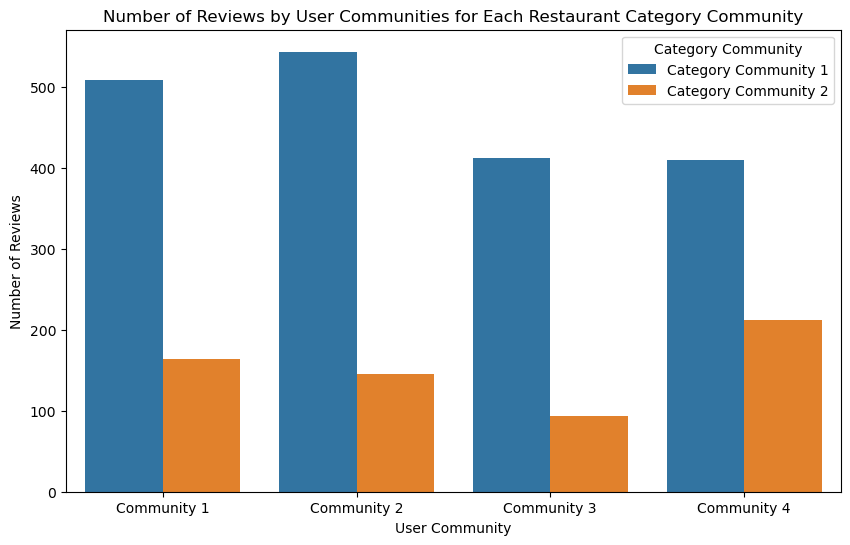

In [113]:

plt.figure(figsize=(10, 6))
sns.barplot(data=df_review_counts, x='user_community', y='review_count', hue='category_community')

plt.title('Number of Reviews by User Communities for Each Restaurant Category Community')
plt.xlabel('User Community')
plt.ylabel('Number of Reviews')
plt.legend(title='Category Community')

plt.show()



Ok, but community 1 of groups of restaurants is larger that comm 2 of catg of restaurants, so this is expected. let's normalize those values:

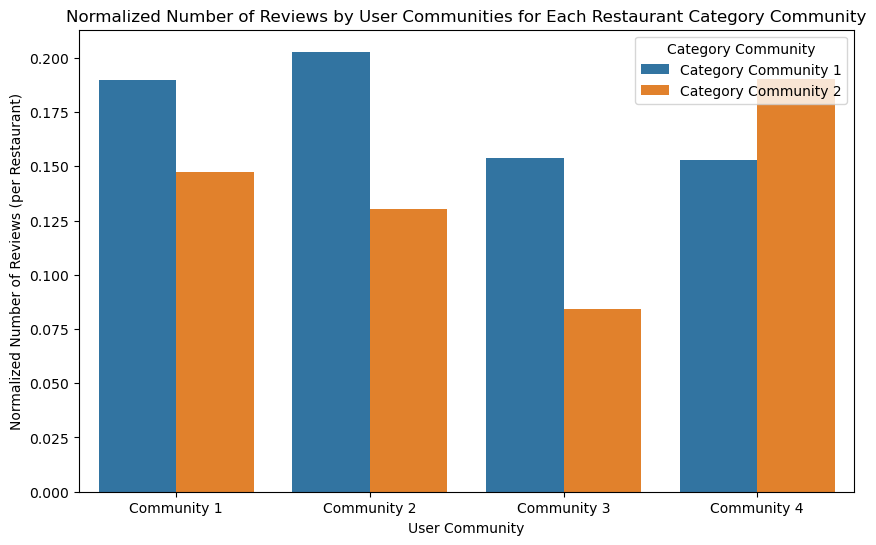

In [114]:
total_restaurants_com_1 = df_com_1_restaurants['business_id'].nunique()
total_restaurants_com_2 = df_com_2_restaurants['business_id'].nunique()

total_restaurants = {
    'Category Community 1': total_restaurants_com_1,
    'Category Community 2': total_restaurants_com_2
}
df_review_counts['normalized_reviews'] = df_review_counts.apply(
    lambda row: row['review_count'] / total_restaurants[row['category_community']], axis=1
)


plt.figure(figsize=(10, 6))
sns.barplot(data=df_review_counts, x='user_community', y='normalized_reviews', hue='category_community')

plt.title('Normalized Number of Reviews by User Communities for Each Restaurant Category Community')
plt.xlabel('User Community')
plt.ylabel('Normalized Number of Reviews (per Restaurant)')
plt.legend(title='Category Community')
plt.show()


Let's analyze the evolution of these reviews over time

In [115]:
# Define a function to assign user community labels
def assign_user_community(user_id):
    if user_id in community_1_users:
        return 'Community 1'
    elif user_id in community_2_users:
        return 'Community 2'
    elif user_id in community_3_users:
        return 'Community 3'
    elif user_id in community_4_users:
        return 'Community 4'
    else:
        return 'Unknown'

# Apply the function to the reviews DataFrame to create the 'user_community' column
df_review['user_community'] = df_review['user_id'].apply(assign_user_community)
# Merge reviews with restaurant categories based on 'business_id'
df_reviews_combined = pd.merge(df_review, df_restaurants, on='business_id', how='inner')


In [116]:
# Check the first few rows and the columns of the merged DataFrame
print(df_reviews_combined.head())
print(df_reviews_combined.columns)


                review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  JrIxlS1TzJ-iCu79ul40cQ  eUta8W_HdHMXPzLBBZhL1A  04UD14gamNjLY0IDYVhHJg   
2  8JFGBuHMoiNDyfcxuWNtrA  smOvOajNG0lS4Pq7d8g4JQ  RZtGWDLCAtuipwaZ-UfjmQ   
3  oyaMhzBSwfGgemSGuZCdwQ  Dd1jQj7S-BFGqRbApFzCFw  YtSqYv1Q_pOltsVPSx54SA   
4  Xs8Z8lmKkosqW5mw_sVAoA  IQsF3Rc6IgCzjVV9DE8KXg  eFvzHawVJofxSnD7TgbZtg   

   stars_x  useful  funny  cool  \
0      5.0       1      0     1   
1      1.0       1      2     1   
2      4.0       0      0     0   
3      5.0       0      0     0   
4      5.0       0      0     0   

                                                                                                                                                                                                                                                                                                                                      

In [118]:
# Ensure 'date' column is in datetime format
df_review['date'] = pd.to_datetime(df_review['date'])

# Extract the year and month from the 'date' column
df_review['year_month'] = df_review['date'].dt.to_period('M')  # Year-Month period


# Filter df_reviews_time_series to only include relevant categories
df_reviews_time_series = df_reviews_time_series[
    df_reviews_time_series['category_community'].isin(relevant_categories)
]


# Merge reviews with restaurant categories based on 'business_id'
df_reviews_combined = pd.merge(df_review, df_restaurants, on='business_id', how='inner')
# Group reviews by year_month, user_community, and category_community
df_reviews_time_series = df_reviews_combined.groupby(
    ['year_month', 'user_community', 'category_community']
).size().reset_index(name='review_count')


# Normalize the review counts by the number of restaurants in each category community
df_reviews_time_series['normalized_reviews'] = df_reviews_time_series.apply(
    lambda row: row['review_count'] / total_restaurants[row['category_community']], axis=1
)


# Set up the figure size
plt.figure(figsize=(14, 8))

# Plot the time series with different lines for user and category communities
sns.lineplot(
    data=df_reviews_time_series,
    x='year_month', 
    y='normalized_reviews', 
    hue='user_community', 
    style='category_community',
    markers=True,
    dashes=False
)

plt.title('Time Series of Normalized Reviews by User and Restaurant Category Community')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Normalized Number of Reviews (per Restaurant)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='User Community / Category Community')
plt.tight_layout()
plt.show()



KeyError: 'Community 2'